# Linear Programming:

Problem: I can work 40 hours a week, I can split my time between two jobs: the first pays $30/hr and the second pays $20/hr, how should I split my time best to maximize my income?

Let's first visualize the cost landscape:

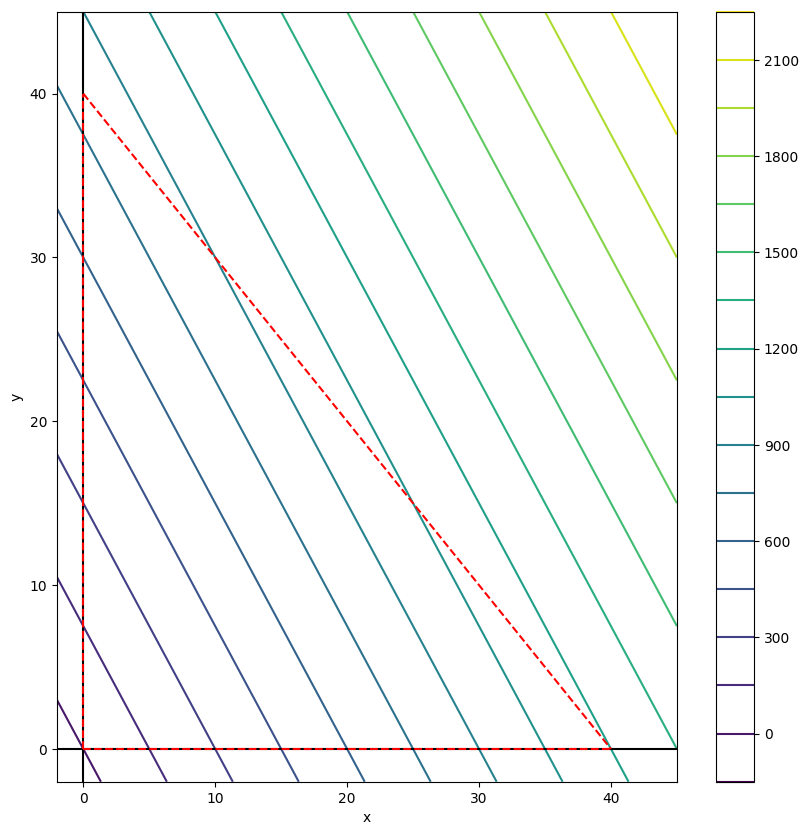

array([[-2.   , -1.525, -1.051, ..., 44.051, 44.525, 45.   ],
       [-2.   , -1.525, -1.051, ..., 44.051, 44.525, 45.   ],
       [-2.   , -1.525, -1.051, ..., 44.051, 44.525, 45.   ],
       ...,
       [-2.   , -1.525, -1.051, ..., 44.051, 44.525, 45.   ],
       [-2.   , -1.525, -1.051, ..., 44.051, 44.525, 45.   ],
       [-2.   , -1.525, -1.051, ..., 44.051, 44.525, 45.   ]])

In [2]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import cvxpy as cp  # installed with `pip install cvxpy`
import scipy as sp  # installed with `pip install scipy`


# define a grid linear in x and y
x = np.linspace(-2, 45, 100)
y = np.linspace(-2, 45, 100)
X, Y = np.meshgrid(x, y)

# define the cost function
cost = 30 * X + 20 * Y

# plot the cost function
def plot_cost(cost, optimal_sol=None):
    plt.figure(figsize=(10, 10))
    plt.contour(X, Y, cost, 20)
    plt.plot(x, 0 * x, 'k')
    plt.plot(0 * y, y, 'k')
    plt.xlabel('x')
    plt.ylabel('y')

    # visualizing the constraints
    plt.plot(np.linspace(0, 40, 100), 0 * np.linspace(0, 40, 100), '--r')
    plt.plot(0 * np.linspace(0, 40, 100), np.linspace(0, 40, 100), '--r')
    plt.plot(np.linspace(0, 40, 100), 40 - np.linspace(0, 40, 100), '--r')

    # if we pass the optimal value,
    if optimal_sol is not None:
        plt.plot(optimal_sol[0], optimal_sol[1], 'or', markersize=15)

    plt.colorbar()
    plt.show()

plot_cost(cost)
X

We expect the maximum to be at (40, 0). Let's verify that our solvers compute this. First, let's use CVXPY:

[[-1.  0.]
 [ 0. -1.]
 [ 1.  1.]]
status: optimal
optimal value -1199.9999980523057
optimal var [4.000e+01 1.878e-08]


/home/prime/.local/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


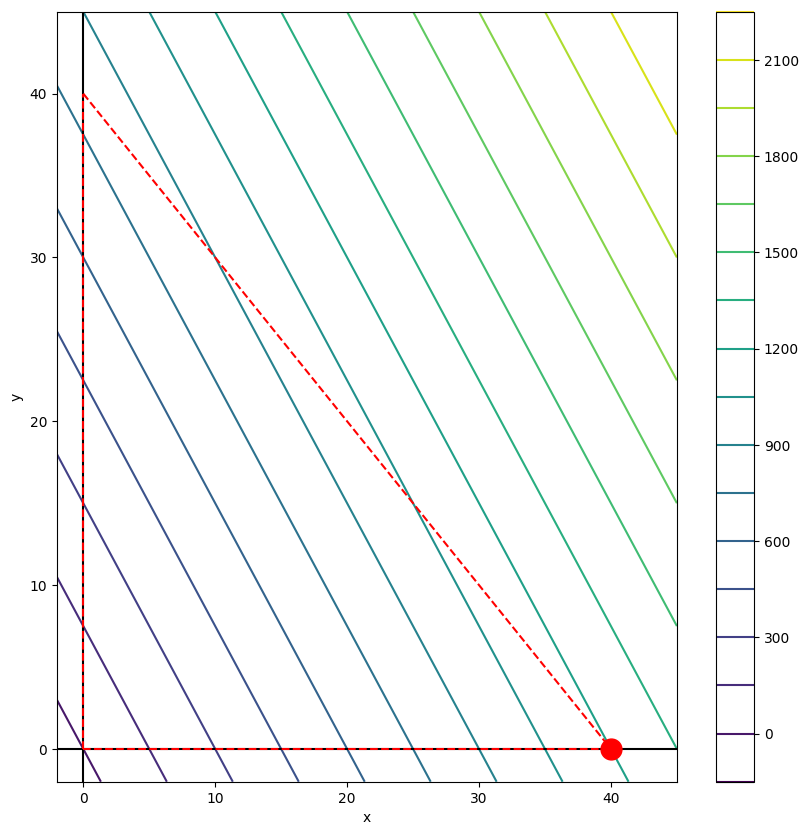

In [3]:
c = np.array([30., 20.])
A = np.array([[-1., 0], [0, -1.], [1., 1.]])
b = np.array([0., 0., 40.])

print(A)

x_cp = cp.Variable(2)
objective = cp.Minimize(- c @ x_cp)
constraints = [A @ x_cp <= b]
prob = cp.Problem(objective, constraints)
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x_cp.value)

plot_cost(cost, x_cp.value)

In [4]:
# now to do the same with scipy
from scipy.optimize import linprog
res = linprog(-c, A_ub=A, b_ub=b, bounds=(0, None))
print(res)


        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -1200.0
              x: [ 4.000e+01  0.000e+00]
            nit: 0
          lower:  residual: [ 4.000e+01  0.000e+00]
                 marginals: [ 0.000e+00  1.000e+01]
          upper:  residual: [       inf        inf]
                 marginals: [ 0.000e+00  0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 4.000e+01  0.000e+00  0.000e+00]
                 marginals: [-0.000e+00 -0.000e+00 -3.000e+01]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0


# Quadratic Programming

Question: assume the same constraints; however, I have a new cost function defined as:

cost = (x - 30)^T Q (x - 30) + p^T x

where Q = eye(2) and p=[[0], [0]]

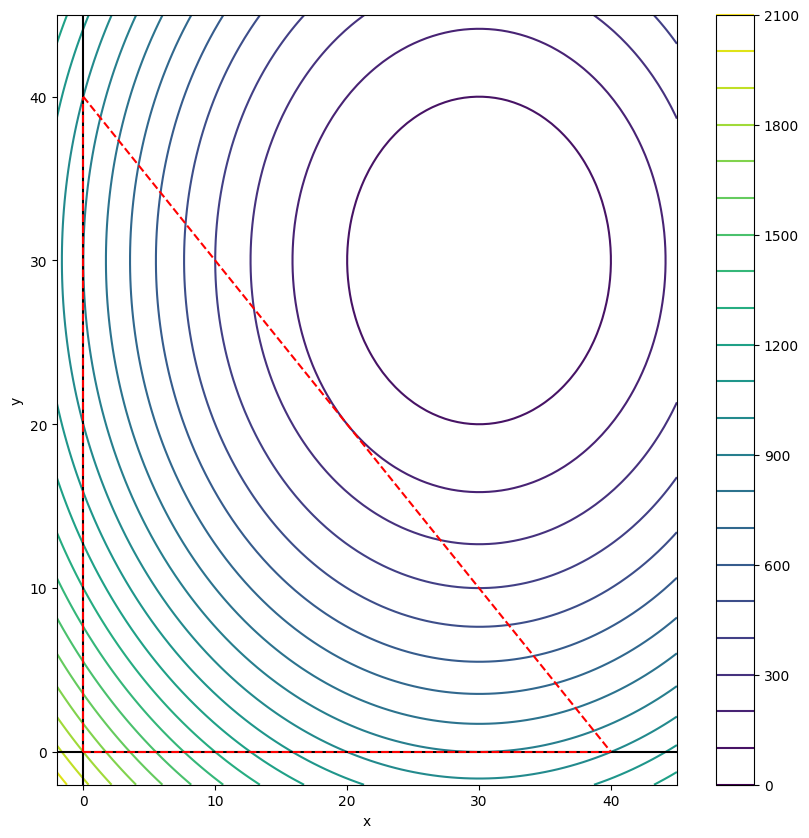

In [5]:
# define a grid linear in x and y
x = np.linspace(-2, 45, 100)
y = np.linspace(-2, 45, 100)
X, Y = np.meshgrid(x, y)

Q = np.eye(2)
p = np.zeros(2)
x_offset = np.array([30., 30.])

# define the cost function
cost = (X-x_offset[0]) ** 2 + (Y - x_offset[1]) ** 2

plot_cost(cost)

---- CVPXPY ----
status: optimal
optimal value -1600.0
optimal var [20. 20.]
---- SCIPY ----
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1599.9999999998777
       x: [ 2.000e+01  2.000e+01]
     nit: 2
     jac: [-2.000e+01 -2.000e+01]
    nfev: 6
    njev: 2


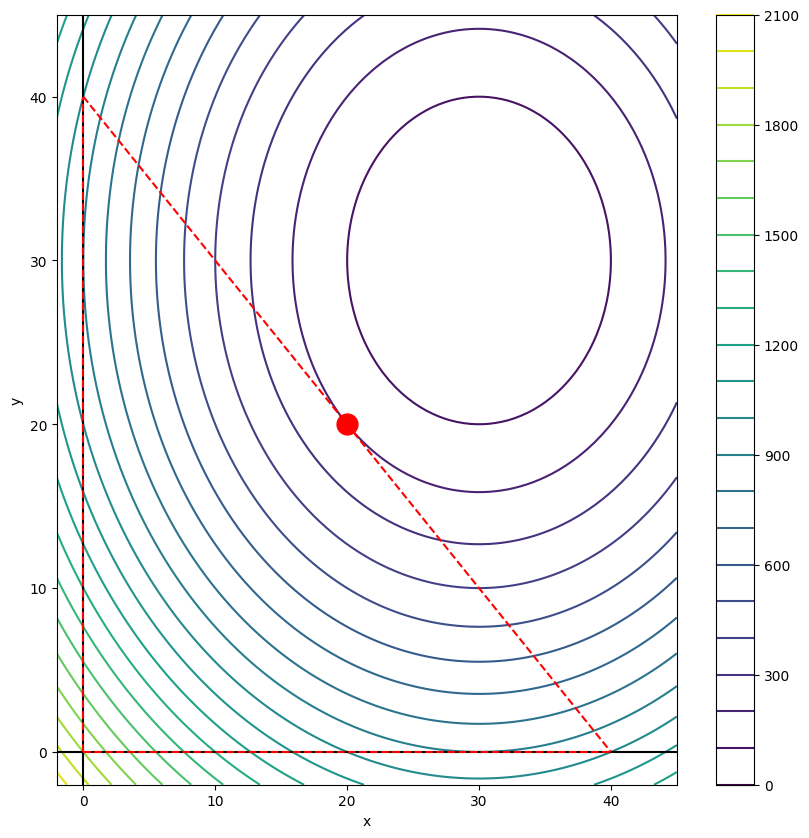

In [6]:
Q = np.eye(2)
p = -2 * x_offset @ Q
A = np.array([[-1., 0], [0, -1.], [1., 1.]])
b = np.array([0., 0., 40.])

x_cp = cp.Variable(2)
objective = cp.Minimize(cp.quad_form(x_cp, Q) + p @ x_cp)
constraints = [A @ x_cp <= b]
prob = cp.Problem(objective, constraints)
prob.solve()

print('---- CVPXPY ----')
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x_cp.value)

# do the same with scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
bounds = Bounds([0, 0], [np.inf, np.inf])
linear_constraint = LinearConstraint(A, -np.inf, b)

def cost_quad(x):
    return x.T @ Q @ x + p @ x

x0 = np.array([0., 0.])
res = sp.optimize.minimize(cost_quad, x0, bounds=bounds, constraints=linear_constraint)
print('---- SCIPY ----')
print(res)

plot_cost(cost, x_cp.value)


# Speeding Up Linear Algebra with GPUs

We'll look at two libraries to do this:

- torch: you can think of this as numpy on the GPU -- the design of this library is intentionally to mirror numpy. 
- jax: jax is from google and specialized for TPU compute. It also does GPU and performance is largely the same for our applications

In [7]:
# check if you have a GPU available in pytorch
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


True
0
1
cuda


In [8]:
# we can easily convert numpy arrays to pytorch tensors
x = np.array([1, 2, 3])
x_torch = torch.from_numpy(x)
print(x_torch)

# we can also convert pytorch tensors to numpy arrays
x_torch = torch.tensor([1, 2, 3])
x = x_torch.numpy()
print(x)

# here is an example of a matrix
A = np.random.randn(3, 3)
A_torch = torch.from_numpy(A)
print(A_torch)

tensor([1, 2, 3])
[1 2 3]
tensor([[ 0.1896,  0.3378, -0.2192],
        [ 3.3233, -0.4363,  0.4678],
        [ 0.1580,  1.3978,  0.3237]], dtype=torch.float64)


In [8]:
# the above is still all in CPU memory, to move it to GPU memory we need to do the following
A_torch = A_torch.to(device)
print(A_torch) # if I had a GPU, this would be on the GPU and tell you what GPU it is on
# to move the tensor back to CPU memory, we do the following
A_torch = A_torch.to('cpu')
print(A_torch)

tensor([[ 1.0766,  1.6246, -1.4953],
        [-0.8073, -1.3896,  2.1287],
        [-1.9832,  0.5365, -0.1949]], dtype=torch.float64)
tensor([[ 1.0766,  1.6246, -1.4953],
        [-0.8073, -1.3896,  2.1287],
        [-1.9832,  0.5365, -0.1949]], dtype=torch.float64)


PyTorch provides access to a variety of BLAS and LAPACK-type routines.

BLAS (Basic Linear Algebra Subprograms) is a library of vector, vector-vector, matrix-vector and matrix-matrix operations. BLAS is very low-level and it is entirely possible you'll never interact with it directly.

LAPACK, a library of dense and banded matrix linear algebra routines such as solving linear systems, the eigenvalue- and singular value decomposition. Still low-level and again, entirely possible you'll never interact with it unless you want to write highly performant code for specialized applications.

The routines you have available to you are found here: https://pytorch.org/docs/stable/torch.html#blas-and-lapack-operations

In [9]:
# pretty much all the numpy functions have a pytorch equivalent
n = 1000
m = 1000
A = np.random.randn(n, m)
B = np.random.randn(n, m)

# time the numpy matrix multiplication
import timeit
numpy_product = 'np.matmul(A, B)'
print('numpy time: {:.2f} seconds'.format(timeit.timeit(numpy_product, number=100, globals=globals())))

A_torch = torch.from_numpy(A).to(device)
B_torch = torch.from_numpy(B).to(device)

# time the pytorch matrix multiplication
pytorch_product = 'torch.matmul(A_torch, B_torch)'
print('\npytorch time: {:.2f} seconds'.format(timeit.timeit(pytorch_product, number=100, globals=globals())))

# some other random things you can do
AB_torch = torch.matmul(A_torch, B_torch)
res = torch.linalg.norm(AB_torch - torch.matmul(A_torch, A_torch))


numpy time: 0.91 seconds

pytorch time: 3.42 seconds


Just by using torch, you should get a significant speed up since the computation is pushed to the GPU (assuming it is available). Why?

CAUTION: if you choose (n,m) too small, the cost of putting the computation onto the GPU and back to the CPU might be more than just doing the computation on CPU. Try significantly increasing (n,m).

You can find the torch linear algebra library here: https://pytorch.org/docs/stable/linalg.html

We have not yet exploited the full power of our GPUs. Let's take a look at batching.

In [10]:
b = 10
n = 1000
m = 1000
A = np.random.randn(b, n, m)
B = np.random.randn(b, n, m)
c = np.random.randn(b, n, 1)
A_torch = torch.from_numpy(A).to(device)
B_torch = torch.from_numpy(B).to(device)
c_torch = torch.from_numpy(c).to(device)

# batch matrix multiplication
matmul_torch = 'torch.matmul(A_torch, B_torch)'
print('pytorch matmul time: {:.2f} seconds'.format(timeit.timeit(matmul_torch, number=10, globals=globals())))

bmm_torch = 'torch.bmm(A_torch, B_torch)'
print('\npytorch bmm time: {:.2f} seconds'.format(timeit.timeit(bmm_torch, number=10, globals=globals())))

# batch matrix multiplication and addition
matmul_with_addition_torch = 'torch.matmul(A_torch, B_torch) + c_torch'
print('\npytorch matmul with addition time: {:.2f} seconds'.format(timeit.timeit(matmul_with_addition_torch, number=10, globals=globals())))

baddbmm_torch = 'torch.baddbmm(c_torch, A_torch, B_torch)'
print('\npytorch baddbmm time: {:.2f} seconds'.format(timeit.timeit(baddbmm_torch, number=10, globals=globals())))


pytorch matmul time: 3.64 seconds

pytorch bmm time: 3.54 seconds

pytorch matmul with addition time: 3.88 seconds

pytorch baddbmm time: 3.66 seconds


If you have a GPU, this is where you're really going to see torch blaze ahead. If you can figure out how to exploit batch operations found here: https://pytorch.org/docs/stable/torch.html#blas-and-lapack-operations you're going to speed up your code orders of magnitude. Note that this is mostly reserved to linear algebra operations.

Let's take a look at jax. It is also designed to emulate numpy as much as possible:

In [11]:
# pip install jax
# pip install jaxlib
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import device_put

A = np.random.randn(n, m)
B = np.random.randn(n, m)
A_jax = device_put(jnp.array(A))
B_jax = device_put(jnp.array(B))

matmul_jax = 'jnp.matmul(A_jax, B_jax)'
print('\njax matmul time: {:.2f} seconds'.format(timeit.timeit(matmul_jax, number=100, globals=globals())))

numpy_product = 'np.matmul(A, B)'
print('\nnumpy matmul time: {:.2f} seconds'.format(timeit.timeit(numpy_product, number=100, globals=globals())))



jax matmul time: 0.47 seconds

numpy matmul time: 1.00 seconds


Jax has very powerful functionalities for compiling code and autodifferentiation. We're going to largely ignore autodiff but we'll take a look at jit. Jit or just in time compilers compile multiple lines of code together using clever backends such as XLA (in the case of jax) to optimize code. Jit is particularly powerful for repeating code. It gives you the ability to create your own optimized vectorization.

In [15]:
def clip_sine(x):
    return jnp.where(jnp.sin(x) > 0, jnp.sin(x), jnp.exp(x))

x = np.linspace(-10, 10, 10 ** 7)
x_jax = device_put(jnp.array(x))

# run and time the function without jit
time_no_jit = timeit.timeit('clip_sine(x_jax).block_until_ready()', number=100, globals=globals())
print('Jax without jit: {:.2f} seconds'.format(time_no_jit))

clip_sine_jit = jit(clip_sine)
time_jit = timeit.timeit('clip_sine_jit(x_jax).block_until_ready()', number=100, globals=globals())
print('Jax with jit: {:.2f} seconds'.format(time_jit))

Jax without jit: 5.23 seconds
Jax with jit: 1.65 seconds
